# Prioritized Experience Replay
This will test the basic code to build an agent with prioritized experience replay (Schaul et al., 2015).

## Initial setup

In [2]:
from vizdoom import *
import sys
sys.path.insert(0, "../python")
from network.Network import Network
import tensorflow as tf
import numpy as np
import math
from time import time
import skimage.transform
import matplotlib.pyplot as plt
%matplotlib inline

## Build replay memory
We will begin by initializing the basic building blocks of replay memory: arrays to store transition values, which include the state (s1), next state (s2), action taken (a), reward received (r), and whether or not the next state is terminal (isterminal).

In [5]:
# Set basic parameters
capacity = 5
state_shape = [30, 45]

# Initialize arrays to store transition variables
s1 = np.zeros([capacity] + list(state_shape), dtype=np.float32)
s2 = np.zeros([capacity] + list(state_shape), dtype=np.float32)
a = np.zeros(capacity, dtype=np.int32)
r = np.zeros(capacity, dtype=np.float32)
isterminal = np.zeros(capacity, dtype=np.float32)        

Now let's define a function that adds a transition to replay memory.

In [6]:
def add_transition(s1_, s2_, a_, r_, isterminal_, pos):
    s1[pos] = s1_
    s2[pos] = s2_
    a[pos] = a_
    r[pos] = r_
    isterminal[pos] = isterminal_

In addition to simply adding the values into the arrays, we also must assign each transition a priority. There are two basic schemes discussed in the paper:
- **Proportional prioritization**: $p_i = |\delta _i| + \epsilon$, where $\epsilon$ is a small constant to avoid edge-cases in which the TD error is zero (and thus leads to zero probability of sampling--see below).
- **Rank-based prioritization**: $p_i = \frac{1}{rank(i)}$, where $rank(i)$ is the priority of transition $i$ when sorted based on $|\delta_i|$.

We will use the proportional-based scheme as its implementation is easier; in reality, both performed equally well overall, although performance varied from game to game.

This function will take $\delta_i = (r_i + Q_i'(s,a)) - Q_i(s,a)$ as input and return the priority $p_i$ of the transition.

In [7]:
def assign_priority(delta):
    return abs(delta) + 0.1

## Binary heap: updating
Sorting and selecting transitions from replay memory becomes prohibitively expensive as the replay memory size grows. If naively implemented, the time to search and insert based on priorities scales as $O(nlogn)$ and $O(n)$, respectively. To reduce this cost, we need to implement a binary heap (see [here](https://jaromiru.com/2016/11/07/lets-make-a-dqn-double-learning-and-prioritized-experience-replay/) for a good explanation).

The binary heap will be implemented using a numpy array. Since we know the number of leaves (i.e. the replay memory capacity), we can compute the total number of elements in the array. If the PER capacity is N, then the previous layer in the heap must be of size $2^{ceil(log(N))-1}$. For example if $N=20$, then the previous layer must be $2^{ceil(log(20))-1}=2^{5-1}=16$; if $N=33$, then it must be $2^{ceil(log(33))-1}=2^{6-1}=32$. The sum of all previous elements is equal to one less than twice the size of the next-to-last-layer:

$\sum_{k=0}^{ceil(log(N))-1} 2^{k}=2*2^{ceil(log(N))-1}-1=2^{ceil(log(N))}-1$

Thus the total number of elements is simply the above plus the number of transitions:

$2^{ceil(log(N))}-1+N$

Because we will being indexing at 1 instead of 0, we will need to add one more to our array capacity:

$2^{ceil(log(N))}+N$

In [8]:
num_leaves = 8
num_elements = 2 ** math.ceil(math.log(num_leaves, 2)) + num_leaves
heap = np.zeros(num_elements, dtype=np.float32)
print(heap.shape)

(16,)


Because we will be adding in unsorted, sequential order, we will simply ad transition priorities from left to right across the bottom layer of the tree. However, while the addition is easy, we must perform additional operations to maintain the specialness of this tree. It is constructed such that the parent node is equal to the sum of the children nodes. When a priority is added, we must propagate the new value up the tree, changing the values of the parent nodes accordingly. Keeping in mind that the indices of the left and right children are given by $2i$ and $2i+1$, respectively, we can formulate the code below.

In [9]:
# Set starting position of transitions in heap
start_pos = 2 ** math.ceil(math.log(num_leaves, 2))
print(start_pos)

# Recursive function to update parent of node j
def _propagate(child_id):
    parent_id = child_id // 2
    heap[parent_id] = heap[2 * parent_id] + heap[2 * parent_id + 1]
    
# Add priority leaf to heap and update parent nodes
def add_priority(p, i, verbose=True):  
    # note that while heap is 1-indexed, RM is still 0-indexed
    j = start_pos + i 
    
    # Add priority of transition i to heap
    heap[j] = p
    
    # Recursively update parent nodes
    while j > 1:
        if verbose: print(j, end=" ")
        _propagate(j)
        j = j // 2
    if verbose: print()

8


Now let's run through an example of propagation. We will add a few priority values to the tree and observe how they are propagated upward to maintain the special structure noted above. We will print which indices were updated and the final value of the heap after updating.

In [10]:
# Initial values
np.set_printoptions(precision=1)
print(heap)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [11]:
# Add priority 3.5
add_priority(3.5, 0)
print(heap)

8 4 2 
[ 0.   3.5  3.5  0.   3.5  0.   0.   0.   3.5  0.   0.   0.   0.   0.   0.
  0. ]


In [12]:
# Add priority 2.2
add_priority(2.2, 1)
print(heap)

9 4 2 
[ 0.   5.7  5.7  0.   5.7  0.   0.   0.   3.5  2.2  0.   0.   0.   0.   0.
  0. ]


In [13]:
# Add priority 4.6
add_priority(4.6, 2)
print(heap)

10 5 2 
[  0.   10.3  10.3   0.    5.7   4.6   0.    0.    3.5   2.2   4.6   0.
   0.    0.    0.    0. ]


Seems to be working! Now let's add a list of numbers to a new heap and see if we get the result as this picture:

![Example of Sum Tree](prioritized_experience_replay/sumtree.png)

(credit: https://jaromiru.com/2016/11/07/lets-make-a-dqn-double-learning-and-prioritized-experience-replay/)

In [29]:
# Create new blank heap
num_leaves = 8
num_elements = 2 ** math.ceil(math.log(num_leaves, 2)) + num_leaves
heap = np.zeros(num_elements, dtype=np.float32)
start_pos = 2 ** math.ceil(math.log(num_leaves, 2))

# List of priorities to add from example above
priorities = [3, 10, 12, 4, 1, 2, 8, 2]

for i, p in enumerate(priorities):
    add_priority(p, i)
    print(heap)

default_heap = heap

8 4 2 
[ 0.  3.  3.  0.  3.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.]
9 4 2 
[  0.  13.  13.   0.  13.   0.   0.   0.   3.  10.   0.   0.   0.   0.   0.
   0.]
10 5 2 
[  0.  25.  25.   0.  13.  12.   0.   0.   3.  10.  12.   0.   0.   0.   0.
   0.]
11 5 2 
[  0.  29.  29.   0.  13.  16.   0.   0.   3.  10.  12.   4.   0.   0.   0.
   0.]
12 6 3 
[  0.  30.  29.   1.  13.  16.   1.   0.   3.  10.  12.   4.   1.   0.   0.
   0.]
13 6 3 
[  0.  32.  29.   3.  13.  16.   3.   0.   3.  10.  12.   4.   1.   2.   0.
   0.]
14 7 3 
[  0.  40.  29.  11.  13.  16.   3.   8.   3.  10.  12.   4.   1.   2.   8.
   0.]
15 7 3 
[  0.  42.  29.  13.  13.  16.   3.  10.   3.  10.  12.   4.   1.   2.   8.
   2.]


## Binary heap: retrieval
They match! Now that we've built the update function, we must add the other side of the coin: binary search. Like a normal binary tree search, the algorithm will be as follows:
    
    if value <= node.left: move left with value
    else:                  move right with (node.left.value - value)

In [15]:
def _search(node, m, verbose):
    # Verbose code to track search
    if verbose:
        print("Node %d, node value %d, search value %d" % (node, heap[node], m))
    
    # Return value if no children
    if 2 * node > heap.size - 1:
        return node, heap[node]
    
    # Move left
    if m <= heap[2 * node]:
        return _search(2 * node, m, verbose)
    
    # Move right
    else:
        m = m - heap[2 * node]
        return _search(2 * node + 1, m, verbose)

def retrieve(m, verbose=True):
    return _search(1, m, verbose=verbose)

In order to sample transitions based on their priority, we need to generate a random number in the range $[0, p_total]$, where $p_total=\sum_{i} p_i$. Then we will match the random number with a transition: if the random number falls in the range of priority values in the cumulative sum function of a transition, we will choose that transition. Let's see an example of randomly generating 24 as above.

In [16]:
rand_int = 24
i, p = retrieve(24)
print("Found transition %d with priority %d" % (i - start_pos, p))

Node 1, node value 42, search value 24
Node 2, node value 29, search value 24
Node 5, node value 16, search value 11
Node 10, node value 12, search value 11
Found transition 2 with priority 12


Awesome! Now let's try with some more random numbers. You can verify the results by looking at the graph above.

In [17]:
rand_int = [12, 29, 35]
for r in rand_int:
    i, p = retrieve(r)
    print("Found transition %d with priority %d" % (i - start_pos, p),
          end="\n\n")

Node 1, node value 42, search value 12
Node 2, node value 29, search value 12
Node 4, node value 13, search value 12
Node 9, node value 10, search value 9
Found transition 1 with priority 10

Node 1, node value 42, search value 29
Node 2, node value 29, search value 29
Node 5, node value 16, search value 16
Node 11, node value 4, search value 4
Found transition 3 with priority 4

Node 1, node value 42, search value 35
Node 3, node value 13, search value 6
Node 7, node value 10, search value 3
Node 14, node value 8, search value 3
Found transition 6 with priority 8



Note that because of the `<=` operator in the `move left` part of the search function, ties go to the leftmost node that contains the random int in its cumulative range.

# Binary heap: performance testing
Now let's run some tests to make sure both the update and search functions scale as $O(logN)$.

In [19]:
sizes = [10 ** (2*x) for x in range(1, 5)]
update_time = []
search_time = []
for i, size in enumerate(sizes):
    print("Creating heap of size %d..." % size)
    
    # Create new blank heap
    num_leaves = size
    num_elements = 2 ** math.ceil(math.log(num_leaves, 2)) + num_leaves
    heap = np.zeros(num_elements, dtype=np.float32)
    start_pos = 2 ** math.ceil(math.log(num_leaves, 2))
    
    # Add random priorities
    priorities = 10 * np.random.random(num_leaves)
    for j in range(num_leaves):
        add_priority(priorities[j], j, verbose=False)
    
    # Test time to update
    start_time = time()
    t = 100000
    for j in range(t):
        #print("Update iteration %d of %d..." % (j+1, t))
        p = 10 * np.random.random()
        k = np.random.randint(0, num_leaves)
        add_priority(p, k, verbose=False)
    end_time = time()
    update_time.append((end_time - start_time) / t)
    
    # Test time to search
    start_time = time()
    t = 10000
    for j in range(t):
        #print("Search iteration %d of %d..." % (j+1, t))
        m = heap[1] * np.random.random()
        retrieve(m, verbose=False)
    end_time = time()
    search_time.append((end_time - start_time) / t)

print("Update times: ", update_time)
update_time_ratios = [update_time[i+1] / update_time[i] for i in range(len(update_time)-2)]
print("Update time ratios: ", update_time_ratios)

print("Search times: ", search_time)
search_time_ratios = [search_time[i+1] / search_time[i] for i in range(len(search_time)-2)]
print("Search time ratios: ", search_time_ratios)

Creating heap of size 100...
Creating heap of size 10000...
Creating heap of size 1000000...
Creating heap of size 100000000...
Update times:  [8.876430988311767e-06, 1.40855073928833e-05, 1.8756589889526367e-05, 3.186120986938477e-05]
Update time ratios:  [1.5868435648776742, 1.331623303751424]
Search times:  [7.93600082397461e-06, 2.2762060165405274e-05, 1.8911123275756837e-05, 2.8120994567871092e-05]
Search time ratios:  [2.868202848044223, 0.8308177352284987]


Hmmm not very informative... might need to check this later on desktop in case this is due to memory issues.

## Drawing random samples with priority-based probability
Now that we've got a working binary heap, we need to test that it samples leaf nodes in proportion to their priority values; that is, the probability $P(i)$ of sampling a transition with a priority $p_i$ is:

$P(i)=\frac{p_i}{\sum_{k} p_k}$

We will first need to encode a way to generate random numbers sampled from $[0, p_tot]$. In order to diversify the transitions sampled while still respecting priority probabilities, we will first divide the range $[0, p_tot]$ into $k$ bins, where $k$ represents the size of the minibatch. Then, from each bin, we will sample one transition uniformly. Let's generate means of creating $k$ random numbers drawn from equally spaced bins:

In [34]:
sample_size = 4

for _ in range(5):
    # Initialize matrices
    m = np.zeros(sample_size)
    
    # Create offset that corresponds to start value of each bin
    offset = np.zeros(sample_size)
    offset[np.arange(sample_size)] = default_heap[1] * np.arange(sample_size) / sample_size
    
    # Draw random numbers from bin size, then add offset to create uniformly spaced distribution
    m[np.arange(sample_size)] = (default_heap[1] / sample_size) * np.random.random(sample_size) + offset

    print("Offset: ", offset)
    print("m:      ", m)
    print()

Offset:  [  0.   10.5  21.   31.5]
m:       [ 10.   17.2  28.5  34. ]

Offset:  [  0.   10.5  21.   31.5]
m:       [  5.7  18.   27.8  38.5]

Offset:  [  0.   10.5  21.   31.5]
m:       [  1.5  16.9  24.7  33.1]

Offset:  [  0.   10.5  21.   31.5]
m:       [  9.   20.3  26.3  36.9]

Offset:  [  0.   10.5  21.   31.5]
m:       [  7.1  19.6  24.5  41.1]



Next, let's utilize these random values to draw samples from our default heap.

In [42]:
def get_sample(sample_size, verbose=True):
    # Initialize matrices
    m = np.zeros(sample_size)
    
    # Create offset that corresponds to start value of each bin
    offset = np.zeros(sample_size)
    offset[np.arange(sample_size)] = default_heap[1] * np.arange(sample_size) / sample_size
    
    # Draw random numbers from bin size, then add offset to create uniformly spaced distribution
    m[np.arange(sample_size)] = (default_heap[1] / sample_size) * np.random.random(sample_size) + offset

    # Get sample for each random number by searching heap
    t = []
    for i in range(sample_size):
        if verbose:
            print(m[i])
        t.append(retrieve(m[i], verbose=verbose))
        if verbose:
            print(t[-1])

heap = default_heap
print(get_sample(4))

2.20069176459
Node 1, node value 42, search value 2
Node 2, node value 29, search value 2
Node 4, node value 13, search value 2
Node 8, node value 3, search value 2
(8, 3.0)
17.9470508164
Node 1, node value 42, search value 17
Node 2, node value 29, search value 17
Node 5, node value 16, search value 4
Node 10, node value 12, search value 4
(10, 12.0)
22.2054647917
Node 1, node value 42, search value 22
Node 2, node value 29, search value 22
Node 5, node value 16, search value 9
Node 10, node value 12, search value 9
(10, 12.0)
41.0275687936
Node 1, node value 42, search value 41
Node 3, node value 13, search value 12
Node 7, node value 10, search value 9
Node 15, node value 2, search value 1
(15, 2.0)
None


## Prioritized Experience Replay Class

Now we will create a PrioritizedReplayMemory class to consolidate our code.

In [114]:
class PrioritizedReplayMemory:
    
    def __init__(self, capacity, state_shape):
        # Initialize arrays to store transition variables
        self.s1 = np.zeros([capacity] + list(state_shape), dtype=np.float32)
        self.s2 = np.zeros([capacity] + list(state_shape), dtype=np.float32)
        self.a = np.zeros(capacity, dtype=np.int32)
        self.r = np.zeros(capacity, dtype=np.float32)
        self.isterminal = np.zeros(capacity, dtype=np.float32) 
        
        # Create new blank heap
        heap_size = 2 ** math.ceil(math.log(capacity, 2)) + capacity
        self.start_pos = 2 ** math.ceil(math.log(capacity, 2))
        self.heap = np.zeros(heap_size, dtype=np.float32)

        self.capacity = capacity
        self.size = 0
        self.pos = 0
    
    def add_transition(self, s1_, s2_, a_, r_, isterminal_, p):
        self.s1[self.pos] = s1_
        self.s2[self.pos] = s2_
        self.a[self.pos] = a_
        self.r[self.pos] = r_
        self.isterminal[self.pos] = isterminal_
        self.add_priority(p, self.pos)
        
        #Increment pointer or start over if reached end
        self.pos = (self.pos + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)
    
    # Recursive function to update parent of node j
    def _propagate(self, child_id):
        parent_id = child_id // 2
        self.heap[parent_id] = self.heap[2 * parent_id] + self.heap[2 * parent_id + 1]

    # Add priority leaf to heap and update parent nodes
    def add_priority(self, p, i):
        # note that while heap is 1-indexed, RM is still 0-indexed
        j = self.start_pos + i 

        # Add priority of transition i to heap
        self.heap[j] = p

        # Recursively update parent nodes
        while j > 1:
            self._propagate(j)
            j = j // 2
    
    # Recursively search for node with cumulative sum range containing number
    def _retrieve(self, node, m):
        # Return value if no children
        if 2 * node > self.heap.size - 1:
            return node

        # Move left
        if m <= self.heap[2 * node]:
            return self._retrieve(2 * node, m)

        # Move right
        else:
            m = m - self.heap[2 * node]
            return self._retrieve(2 * node + 1, m)

    # Get random sample corresponding to random number m
    def get_sample(self, sample_size):
        # Initialize matrices
        m = np.zeros(sample_size)

        # Create offset that corresponds to start value of each bin
        offset = np.zeros(sample_size)
        offset[np.arange(sample_size)] = self.heap[1] * np.arange(sample_size) / sample_size
        
        # Draw random numbers from bin size, then add offset to create uniformly spaced distribution
        m[np.arange(sample_size)] = (self.heap[1] / sample_size) * np.random.random(sample_size) + offset

        t = np.zeros(sample_size, dtype=np.int32)
        for i in range(sample_size):
            t[i] = self._retrieve(1, m[i]) - self.start_pos

        return self.s1[t], self.a[t], self.s2[t], self.r[t], self.isterminal[t], t

## Example: DQN in ViZDoom environment

Normally, we would manipulate (hyper)parameters within an agent file, but currently, the agent is only set up to utilize a uniform replay memory. thus in this case, we will hard code parameters below to create a network, and then build our new prioritized ER from scratch.

In [63]:
tf.reset_default_graph()

# Set network parameters
phi = 1
num_channels = 1
output_shape = 4
output_directory = "../tmp/"
sess = tf.Session()
train_mode = True
lr = 0.01
net_file = "../networks/dqn_basic.json"

# Create main network
main_network = Network(phi=phi, 
                       num_channels=num_channels, 
                       output_shape=output_shape,
                       train_mode=True,
                       learning_rate=lr,
                       network_file=net_file,
                       params_file=None,
                       output_directory=output_directory,
                       session=sess,
                       scope="main_network")

# Create target network used to calculate target Q values
target_network = Network(phi=phi, 
                         num_channels=num_channels, 
                         output_shape=output_shape,
                         learning_rate=lr,
                         train_mode=True,
                         network_file=net_file,
                         params_file=None,
                         output_directory=output_directory,
                         session=sess,
                         scope="target_network")

In [131]:
# Create PER to store and sample transitions
capacity = 100
memory = PrioritizedReplayMemory(capacity, main_network.input_shape)

In [132]:
# Load DoomGame instance
game = DoomGame()
game.load_config("prioritized_experience_replay/per_test.cfg")
game.init()

True

In [133]:
def preprocess(img):
    img = skimage.transform.resize(img, main_network.input_shape, mode='constant')
    img = img.astype(np.float32)
    return img
    
for i in range(capacity):
    s1 = preprocess(game.get_state().screen_buffer)
    a = [1, 0, 0]
    r = game.make_action(a, 4)
    isterminal = game.is_episode_finished()
    if isterminal:
        s2 = None
        game.new_episode()
    else:
        s2 = preprocess(game.get_state().screen_buffer)
    p = 3 * abs(np.random.normal(loc=0, scale=10.0)) + 0.1
    memory.add_transition(s1, s2, 0, r, isterminal, p)

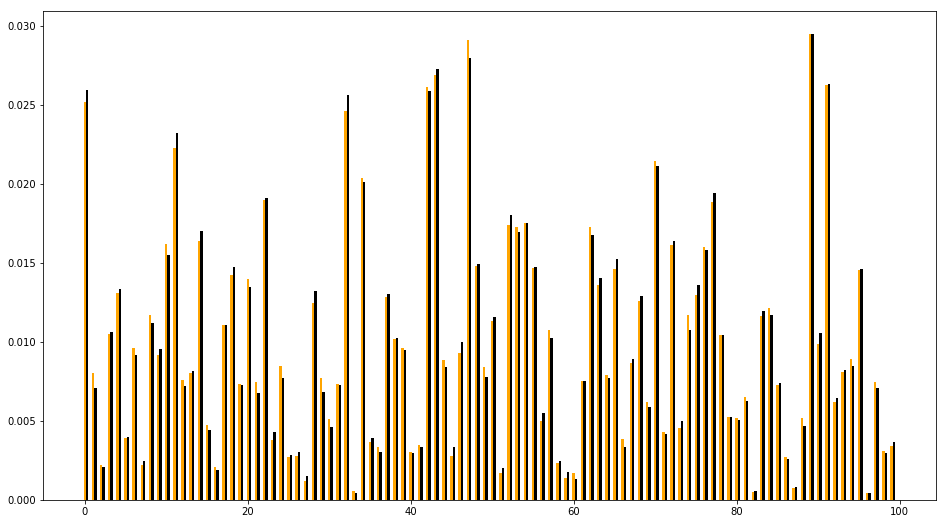

In [153]:
# Get samples
t = []
for i in range(1000):
    _, _, _, _, _, t_i = memory.get_sample(32)
    t.append(t_i)

t = np.asarray(t)

# Count how many times each 
p_tot = memory.heap[1]
calc_prob = np.zeros(capacity)
actual_prob = np.zeros(capacity)
for i in range(capacity):
    p = memory.heap[memory.start_pos + i]
    calc_prob[i] = p / p_tot
    actual_prob[i] = np.sum(np.count_nonzero(t == i)) / t.size
    #print("Transition %d: calculated prob=%.3f, actual prob=%.3f" % (i, calc_prob, actual_prob))

fig, ax = plt.subplots()
idx = np.arange(capacity)
width = 0.3
ax.bar(idx, calc_prob, width, color="orange")
ax.bar(idx + width, actual_prob, width, color="black")
fig.set_size_inches(16, 9)
plt.show()

Pretty close!

## Debugging divide_by_zero error
The following error occurs rarely but halts training completely:

```
/home/james/DRL/ViZDoom/myvizdoom/python/memory/PrioritizedReplayMemory.py:108: RuntimeWarning: divide by zero encountered in true_divide
  w = (1 / self.size + 1 / P) ** self.beta
```

### Trial 1
Placing some debugging code in the `PrioritizedReplayMemory` class led to the following output after such an occurrence:

```
t_:  [132420 134708 137428 140284 143106 143978 146100 150787 152174 155741
 156766 159138 162823 165159 166859 169157 172953 175232 176509 178939
 182925 184194 187485 189666 191278 195368 197115 200669 201038 205862
 206161 106495]
heap[t_]:  [ 0.23203613  0.24098936  0.79097128  2.3553133   1.75138795  0.38908565
  0.24508314  0.43584165  0.38867164  0.24647366  0.26096773  0.29170811
  2.05461168  0.16835532  0.85869598  0.36499071  0.14356624  0.32087034
  0.59336162  0.24211463  0.20079562  0.266231    0.52754629  0.63639134
  2.22522616  0.19536662  0.18007174  0.2150154   0.40188783  0.23568983
  0.19346124  0.        ]
heap[1]:  24183.8
P:  [  9.59470435e-06   9.96492145e-06   3.27066991e-05   9.73923161e-05
   7.24199708e-05   1.60887103e-05   1.01341993e-05   1.80220723e-05
   1.60715899e-05   1.01916976e-05   1.07910282e-05   1.20621444e-05
   8.49582866e-05   6.96150028e-06   3.55071206e-05   1.50923834e-05
   5.93647064e-06   1.32680034e-05   2.45355313e-05   1.00114512e-05
   8.30290810e-06   1.10086639e-05   2.18140631e-05   2.63148122e-05
   9.20132079e-05   8.07841934e-06   7.44597492e-06   8.89089642e-06
   1.66180798e-05   9.74578597e-06   7.99963163e-06   0.00000000e+00]
size:  80000
beta:  0.48100000000000004
w:  [ 259.2046814   254.52714539  143.70098877   85.01971436   98.04109192
  202.1451416   252.47322083  191.40705872  202.24868774  251.78707886
  244.96092224  232.18536377   90.79293823  302.45443726  138.13327026
  208.45748901  326.53738403  221.78416443  165.0092926   253.95744324
  277.8755188   242.61949158  174.60945129  159.54518127   87.37518311
  281.56329346  292.82339478  268.87921143  199.02180481  257.2640686
  282.89376831           inf]
```

The actual size of the numpy array `heap` is given by:

In [2]:
import math
capacity = 80000
heap_size = 2 ** math.ceil(math.log(capacity, 2)) + capacity
print(heap_size)

211072


The last 80000 positions of the heap represent leaves, or priorities tied to stored transitions. The rest are intermediate nodes that should not be sampled directly. The leaves begin at position:

In [4]:
start_pos = 2 ** math.ceil(math.log(capacity, 2))
print(start_pos)

131072


Thus the sample 106495 should not have been taken. This index probably represents the rightmost branches of the binary tree that have no leaf nodes and thus no values (since parents equal sum of children in this special heap). Here is the code for obtaining samples from PER (along with debugging print statements):

In [ ]:
def get_sample(self, sample_size):
        # Initialize matrices
        m = np.zeros(sample_size)

        # Create offset that corresponds to start value of each bin
        offset = np.zeros(sample_size)
        offset[np.arange(sample_size)] = ( self.heap[1] 
                                           * np.arange(sample_size) / sample_size )
        
        # Draw random numbers from bin size, 
        # then add offset to create uniformly spaced distribution
        m[np.arange(sample_size)] = ( (self.heap[1] / sample_size)
                                       * np.random.random(sample_size) + offset )

        # Retrieve transition indices with probability proportional
        # to priority values
        t = np.zeros(sample_size, dtype=np.int32)
        for i in range(sample_size):
            t[i] = self._retrieve(1, m[i]) - self.start_pos
        
        # Calculate importance-sampling (IS) weights w_i of transition:
        # w_i = (1/N * 1/P_i) ** β
        # where P_i = probability of transition i, N = memory size, 
        # and β = hyperparameter
        t_ = self.start_pos + t
        P = self.heap[t_] / self.heap[1]
        w = (1 / self.size + 1 / P) ** self.beta
        w = w / np.max(w) # normalize weights so all <= 1.0
        if (P == 0).any() or self.size == 0:
            print("t_: ", t_)
            print("heap[t_]: ", self.heap[t_])
            print("heap[1]: ", self.heap[1])
            print("P: ", P)
            print("size: ", self.size)
            print("beta: ", self.beta)
            print("w: ", w)
            #np.savetxt("../tmp/tmp_results/heap.txt", self.heap)
        
        # Stack overlapping frames from s1 to stored frames of s2 to
        # recreate full s2 state
        if self.overlap > 0:    
            s2 = np.concatenate((self.s1[[t] + [slice(None)] * self.chdim 
                                 + [slice(None, self.overlap)]], 
                                 self.s2[t]), 
                                 axis=self.chdim+1)
        else:
            s2 = self.s2[t]

        return self.s1[t], self.a[t], s2, self.isterminal[t], self.r[t], w, t

Let's run the first section of code to make sure there are no obvious errors.

In [6]:
import numpy as np

sample_size = 32
heap_1 = 24183.8

# Initialize matrices
m = np.zeros(sample_size)

# Create offset that corresponds to start value of each bin
offset = np.zeros(sample_size)
offset[np.arange(sample_size)] = ( heap_1
                                   * np.arange(sample_size) / sample_size )

# Draw random numbers from bin size, 
# then add offset to create uniformly spaced distribution
m[np.arange(sample_size)] = ( (heap_1 / sample_size)
                               * np.random.random(sample_size) + offset )

print("m: ", m)
print("offset: ", offset)

m:  [   495.22668181   1057.47822678   1936.00505265   2955.88952402
   3615.79895958   4492.79984344   4986.08394442   5492.47753336
   6696.38173415   7382.0807392    8092.75284115   8828.18859286
   9460.07466548  10369.55243044  10813.91309189  11363.46859654
  12129.16979983  13256.78818569  13873.01283026  14632.18655498
  15768.88803377  16457.99541593  16663.10143242  17930.8221608
  18819.54953062  19485.24513183  20082.04107018  20691.62395053
  21768.2299554   22124.02567792  23313.02903128  23868.57877195]
offset:  [     0.         755.74375   1511.4875    2267.23125   3022.975
   3778.71875   4534.4625    5290.20625   6045.95      6801.69375
   7557.4375    8313.18125   9068.925     9824.66875  10580.4125
  11336.15625  12091.9      12847.64375  13603.3875   14359.13125
  15114.875    15870.61875  16626.3625   17382.10625  18137.85     18893.59375
  19649.3375   20405.08125  21160.825    21916.56875  22672.3125
  23428.05625]


It looks good. Here is the traceback from the node that caused the zero division error:

In [17]:
node = 106495
print(node)
while node > 1:
    p = node
    c = node // 2
    if p % c == 0:
        print(c, " moved left")
    else:
        print(c, " moved right")
    node = c

106495
53247  moved right
26623  moved right
13311  moved right
6655  moved right
3327  moved right
1663  moved right
831  moved right
415  moved right
207  moved right
103  moved right
51  moved right
25  moved right
12  moved right
6  moved left
3  moved left
1  moved left


The rightmost leaf has the following traceback:

In [18]:
node = 211072
print(node)
while node > 1:
    p = node
    c = node // 2
    if p % c == 0:
        print(c, " moved left")
    else:
        print(c, " moved right")
    node = c

211072
105536  moved left
52768  moved left
26384  moved left
13192  moved left
6596  moved left
3298  moved left
1649  moved left
824  moved right
412  moved left
206  moved left
103  moved left
51  moved right
25  moved right
12  moved right
6  moved left
3  moved left
1  moved left


Thus at node 103, the retrieve function should have moved left but instead moved right, putting it on a branch that had no terminal leaf nodes. After that decision, it only moved right the rest of the way likely because all nodes it was encountering were 0. Unfortunately, it is difficult to see why this happened at node 103 unless we have access to the full `heap` array, which I will save during the next debugging run.

### Trial 2
This time, I saved the heap values to `heap.csv` and got the following debugging print out after ~ 500,000 learning steps:
```
m: [   1839.63825045    4295.68753363    7978.25184885   11267.53480135
   16367.02605193   21243.5353934    24372.04660502   26462.43133402
   31852.52263506   32418.79534471   36479.43148083   41979.9850571
   45860.06704717   49625.81022126   53302.31829694   54461.63846034
   58726.49416338   62097.08856989   67398.40005856   69241.81091996
   74107.12231262   77081.00921093   82183.06112002   84418.09530725
   86759.02481597   92552.67349783   93611.22490686   98538.00485737
  103135.73647588  107257.0802528   108322.32956015  115090.9649345 ]
  
t_:  [132344 134148 136777 139079 142612 145905 147951 149220 152427 152701
 153669 156962 159839 162542 165305 166245 169427 172084 175929 177390
 180999 183137 186888 188608 190304 194642 195397 198906 202371 205315
 206142 131071]
 
heap[t_]:  [  3.57136917   0.59005439   3.57996511   2.5988493    2.42636847
   3.53408241   1.85923672   4.25455856   4.0738759    3.1902113
  37.12011719   5.91703987   1.92212605   0.58849883   0.60191655
   1.94672382   2.38106942   2.90546632   1.20598602   2.63270354
   3.64027071   5.93819237   4.39834642   1.10890043   1.08353031
   1.53687251   3.5494628    1.83276606   0.49460229   4.64636326
   1.90546358   0.        ]
   
heap[1]:  115091.0

P:  [  3.10308387e-05   5.12685210e-06   3.11055264e-05   2.25808271e-05
   2.10821800e-05   3.07068622e-05   1.61544976e-05   3.69669178e-05
   3.53970063e-05   2.77190411e-05   3.22528504e-04   5.14118510e-05
   1.67009293e-05   5.11333610e-06   5.22992013e-06   1.69146533e-05
   2.06885870e-05   2.52449554e-05   1.04785458e-05   2.28749795e-05
   3.16295082e-05   5.15956417e-05   3.82162616e-05   9.63499042e-06
   9.41455528e-06   1.33535459e-05   3.08404997e-05   1.59244992e-05
   4.29749025e-06   4.03712256e-05   1.65561523e-05   0.00000000e+00]
   
size:  80000

beta:  0.7
```
Remember that `m` represents the cumulative sum value to search for, and `t_` represents the heap index corresponding to the cumulative sum `m`. Let's define the functions for PER and load the saved heap, walking through the recursive search step-by-step. The error occurred for the last index, with `m=115090.9649345` and `t_=131071`.

In [15]:
def retrieve(node, m):
    print("Node:", node, "; m:", m, end = " ; ")
    # Return value if no children (i.e. leaf)
    if 2 * node > heap.size - 1:
        return node
    
    print("Left child:", heap[2*node], end=" ; ")
    # Move left
    if m <= heap[2 * node]:
        print("Move left")
        return retrieve(2 * node, m)

    # Move right
    else:
        print("Move right")
        m = m - heap[2 * node]
        return retrieve(2 * node + 1, m)

In [ ]:
heap = np.loadtxt('./prioritized_experience_replay/heap.csv')

So this replicates what was seen in the printout above. Let's now walk through it step-by-step.

In [17]:
retrieve(1, 115090.9649345)

Node: 1 ; m: 115090.9649345 ; Left child: 95317.59375 ; Move right
Node: 3 ; m: 19773.3711845 ; Left child: 19773.3710938 ; Move right
Node: 7 ; m: 9.07500070753e-05 ; Left child: 0.0 ; Move right
Node: 15 ; m: 9.07500070753e-05 ; Left child: 0.0 ; Move right
Node: 31 ; m: 9.07500070753e-05 ; Left child: 0.0 ; Move right
Node: 63 ; m: 9.07500070753e-05 ; Left child: 0.0 ; Move right
Node: 127 ; m: 9.07500070753e-05 ; Left child: 0.0 ; Move right
Node: 255 ; m: 9.07500070753e-05 ; Left child: 0.0 ; Move right
Node: 511 ; m: 9.07500070753e-05 ; Left child: 0.0 ; Move right
Node: 1023 ; m: 9.07500070753e-05 ; Left child: 0.0 ; Move right
Node: 2047 ; m: 9.07500070753e-05 ; Left child: 0.0 ; Move right
Node: 4095 ; m: 9.07500070753e-05 ; Left child: 0.0 ; Move right
Node: 8191 ; m: 9.07500070753e-05 ; Left child: 0.0 ; Move right
Node: 16383 ; m: 9.07500070753e-05 ; Left child: 0.0 ; Move right
Node: 32767 ; m: 9.07500070753e-05 ; Left child: 0.0 ; Move right
Node: 65535 ; m: 9.07500070753

131071

Looking at the traceback from the rightmost node above (trial 1), the search cannot move to the right at Node 3; otherwise, it continues on a nonsense path that contains unused nodes. The total cumulative sum is given by `heap[1]` (1-indexed), which serves as the basis for generating random samples from uniformly distributed bins (i.e. generating `m`). The value of `m` is less than `heap[1]=115091.0`, which is good, but let's check the children nodes:

In [22]:
print("heap[2]:", heap[2], "; heap[3]", heap[3])
print("heap[2] + heap[3] =", heap[2] + heap[3])
print("heap[1]:", heap[1])
print("calculated total:", np.sum(heap[131072:]))

heap[2]: 95317.59375 ; heap[3] 19773.3710938
heap[2] + heap[3] = 115090.964844
heap[1]: 115090.96875
calculated total: 115090.964338


So the issue lies in the propagation function that updates parent nodes: over many iterations, slight numerical errors in propagation up the tree accumulate to cause `heap[1]` to slightly differ from the actual total of all leaves in the tree. In this case, the difference is only a few-thousandths, but the value of `m` snuck into this small interval:

```
calculated total < heap[2] + heap[3] < m              < heap[1]
115090.964338      115090.964844       115090.9649345   115090.96875
```

The same thing probably occurred in trial 1 further down the tree, where the `m` value snuck into a similar inaccuracy interval between the parent and children nodes.

To fix this, it would probably be best to pad `m` on the border cases, but the value will depend on the size and values of the replay memory. If too small, it might not cover the inaccuracy gap and allow the same error, but if too large, it might prohibit the first and last bin(s) from being accessible. For now, since the error occurs so rarely (every ~ 100,000 steps), I will cover errors with a `try-except` clause and increase the `heap` data type to `np.float64`.

## Checking prioritization accuracy of actual heap
Using the heap above for debuggin (trial 2), let's walk through our validation steps shown earlier to be sure that the prioritization is sampling correctly in practice.

In [5]:
heap = np.loadtxt('./prioritized_experience_replay/heap.csv')
capacity = 80000
start_pos = 2 ** math.ceil(math.log(capacity, 2))

In [6]:
# Recursively search for node with cumulative sum range containing number
def retrieve(node, m):
    # Return value if no children
    if 2 * node > heap.size - 1:
        return node

    # Move left
    if m <= heap[2 * node]:
        return retrieve(2 * node, m)

    # Move right
    else:
        m = m - heap[2 * node]
        return retrieve(2 * node + 1, m)

# Get random sample corresponding to random number m
def get_sample(sample_size):
    # Initialize matrices
    m = np.zeros(sample_size)

    # Create offset that corresponds to start value of each bin
    offset = np.zeros(sample_size)
    offset[np.arange(sample_size)] = heap[1] * np.arange(sample_size) / sample_size

    # Draw random numbers from bin size, then add offset to create uniformly spaced distribution
    m[np.arange(sample_size)] = (heap[1] / sample_size) * np.random.random(sample_size) + offset

    t = np.zeros(sample_size, dtype=np.int32)
    for i in range(sample_size):
        t[i] = retrieve(1, m[i]) - start_pos

    return t

In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

Sampling...Done.
Calculating probs...Done.
Plotting...


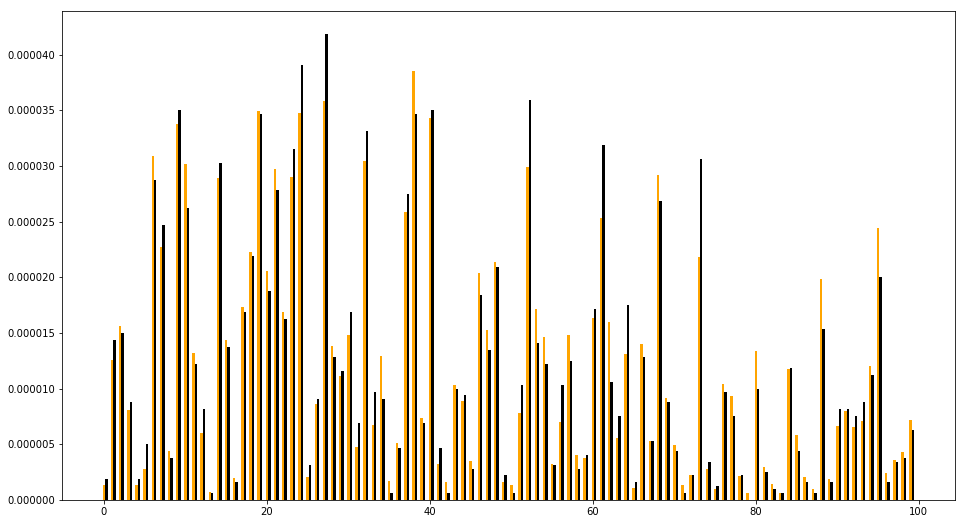

In [13]:
import random

# Get samples
batch_size = 32
num_batches = 100000
t = []
print("Sampling...", end=""), sys.stdout.flush()
for i in range(num_batches):
    t_i = get_sample(batch_size)
    t.append(t_i)
print("Done."), sys.stdout.flush()

t = np.asarray(t)

# Count how many times each
sample_size = 100
p_tot = heap[1]
calc_prob = np.zeros(sample_size)
actual_prob = np.zeros(sample_size)
print("Calculating probs...", end=""), sys.stdout.flush()
for j, i in enumerate(random.sample(range(capacity), sample_size)):
    p = heap[start_pos + i]
    calc_prob[j] = p / p_tot
    actual_prob[j] = np.sum(np.count_nonzero(t == i)) / t.size
    #print("Transition %d: calculated prob=%.3f, actual prob=%.3f" % (i, calc_prob, actual_prob))
print("Done."), sys.stdout.flush()

print("Plotting..."), sys.stdout.flush()
fig, ax = plt.subplots()
idx = np.arange(sample_size)
width = 0.3
ax.bar(idx, calc_prob, width, color="orange")
ax.bar(idx + width, actual_prob, width, color="black")
fig.set_size_inches(16, 9)
plt.show()

Pretty good match!